In [1]:
# # !pip install seaborn
# # !pip install scipy
# # !pip install ipywidgets
# !pip install torch

In [1]:

import numpy as np
from glicko2 import load_data
import seaborn as sns
import pandas as pd
import torch
from competition_utils import bot_list

In [2]:
data = load_data()
print((data.keys()))
del data["alphazero_v1_flat"]
del data["human"]
del data["alphazero_flat_v1"]
print(len(data))
print(len(bot_list))
index = ["" for _ in range(len(data))]
new_ratings = [0 for _ in range(len(data))]
indices = []
ind_to_bot = {}
for b in bot_list:
    i = data[b]["index"]
    indices.append(i)
    ind_to_bot[i] = b

    print(i, b)
    if i == len(index):
        i-= 1
    index[i] = (int(round(data[b]["full_elo"])), b)
    new_ratings[i] = data[b]["full_elo"]
print(index)


dict_keys(['floyd_combined', 'moves', 'floyd', 'floyd_u', 'markers', 'random', 'connections', 'floyd_d=2', 'negative_floyd', 'human', 'alphazero_flat_v1', 'alphazero_v1_flat'])
9
9
5 random
2 floyd
0 floyd_combined
3 floyd_u
6 connections
1 moves
4 markers
7 floyd_d=2
8 negative_floyd
[(1611, 'floyd_combined'), (1604, 'moves'), (1735, 'floyd'), (1748, 'floyd_u'), (1597, 'markers'), (1227, 'random'), (1743, 'connections'), (1638, 'floyd_d=2'), (860, 'negative_floyd')]


In [3]:

wins1 = np.load("scores/wins1.npy")
bool_inds = [[True if i in indices else False for i in range(wins1.shape[0])],[True if i in indices else False for i in range(wins1.shape[1])]]
print(bool_inds)
wins1 = wins1[bool_inds[0],:][:,bool_inds[1]]
draws1 = np.load("scores/draws1.npy")[bool_inds[0],:][:,bool_inds[1]]
losses1 = np.load("scores/losses1.npy")[bool_inds[0],:][:,bool_inds[1]]
wins2 = np.load("scores/wins2.npy")[bool_inds[0],:][:,bool_inds[1]]
draws2 = np.load("scores/draws2.npy")[bool_inds[0],:][:,bool_inds[1]]
losses2 = np.load("scores/losses2.npy")[bool_inds[0],:][:,bool_inds[1]]
print((wins1+0.5 *draws1+wins2+0.5 *draws2)/np.amax(wins1+wins2+draws1+draws2+losses1+losses2,1))

[[True, True, True, True, True, True, True, True, True, False, False, False, False], [True, True, True, True, True, True, True, True, True, False, False, False, False]]
[[0.         0.5        0.3        0.4137931  0.65517241 1.
  0.43333333 0.43333333 0.93333333]
 [0.43333333 0.         0.43333333 0.37931034 0.4137931  0.95
  0.53333333 0.4        1.        ]
 [0.63333333 0.53333333 0.         0.48275862 0.62068966 1.
  0.66666667 0.51666667 0.96666667]
 [0.53333333 0.56666667 0.5        0.         0.55172414 0.96666667
  0.5        0.73333333 0.96666667]
 [0.3        0.53333333 0.33333333 0.4137931  0.         0.95
  0.33333333 0.4        0.96666667]
 [0.         0.01666667 0.         0.         0.01724138 0.
  0.         0.01666667 0.93333333]
 [0.53333333 0.43333333 0.3        0.48275862 0.62068966 0.93333333
  0.         0.66666667 0.96666667]
 [0.56666667 0.56666667 0.41666667 0.24137931 0.55172414 0.91666667
  0.33333333 0.         0.96666667]
 [0.         0.         0.         

In [4]:
wins = wins1 + wins2
wins = wins - np.diag(np.diag(wins))
losses = losses1 + losses2
losses = losses - np.diag(np.diag(losses))
total_games = wins1+losses1+draws1+wins2+losses2+draws2
total_games = total_games - np.diag(np.diag(total_games))

for _ in range(100):
    ratings = new_ratings
    total_ratings = np.zeros(losses1.shape)

    for b in bot_list:
        i = data[b]["index"]
        # ratings if same games were repeated
        total_ratings[:,i] = ratings[i] * (wins1[:,i] + losses1[:,i] + draws1[:,i] + wins2[:,i] + losses2[:,i] + draws2[:,i])


    new_ratings = np.sum(total_ratings + 400 * (wins - losses), axis = 1)/np.sum(total_games, axis=1)
    m = np.mean(new_ratings)
    new_ratings = [r-m+1500 for r in new_ratings]
print(ratings)
print(new_ratings)

[1574.0840173908025, 1560.0284034046322, 1640.9385764089577, 1636.3228988607477, 1539.123174292465, 1235.9375756918646, 1597.039687518223, 1563.0670646867356, 1153.458601745572]
[1574.0840173908025, 1560.0284034046322, 1640.9385764089577, 1636.3228988607477, 1539.123174292465, 1235.9375756918646, 1597.039687518223, 1563.0670646867356, 1153.458601745572]


In [5]:
index = [(int(round(nr)),name[1]) for nr, name in zip(new_ratings,index)]
print(sum(sum(total_games)))

2068.0


Average score for row against column (bootstrapped elos instead of performance elo)


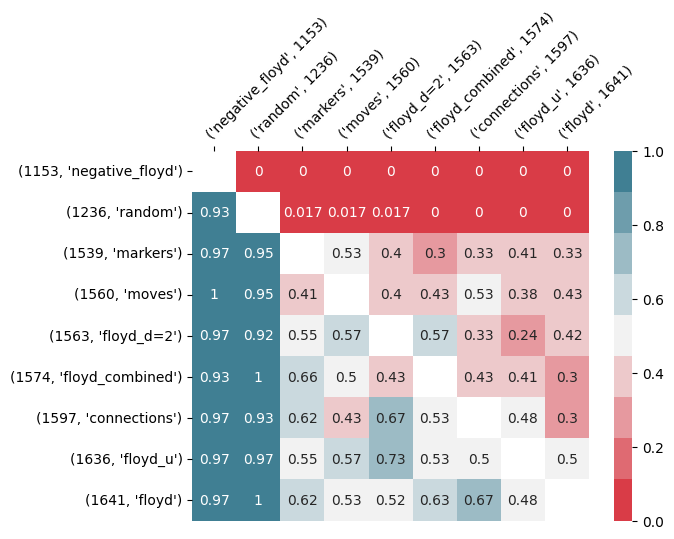

In [6]:
draws1 += np.eye(draws1.shape[0])
num_games = ( 1
        * wins1 
        + losses1 
        + wins2 
        + losses2
        + draws1 
        + draws2 
    )
ave_scores = ( 1
    * wins1
    + wins2 
    + 0.5 * draws1 
    + 0.5 * draws2
    # # - losses1
    # # - losses2
    ) /  (1 
        * np.amax(num_games,1)
    )
arr = num_games
arr = ave_scores
arr = arr - np.diag(np.diag(arr))
new_order = sorted(list(zip(list(range(len(index))), index)), key = lambda x: x[1][0])
new_index = [index[i[0]] for i in new_order]
new_arr = np.zeros(arr.shape)
for ni, ai in enumerate(new_order):
    new_arr[ni,:] = arr[ai[0],:]
for ai, ni in enumerate(new_order):
    arr[:,ai] = new_arr[:, ni[0]]
del new_arr
try:
    del df
except:
    pass
df = pd.DataFrame(data = arr, index = new_index, columns = new_index)
ax = sns.heatmap(df,annot=True, #annot_kws={'rotation': 60},
# vmax=1, 
# vmin=0,
mask = np.eye(arr.shape[0]),
cmap = [(0.2519971417644415, 0.4987337088076726, 0.5751602783606602),
 (0.43156001218774975, 0.6160490836499025, 0.6735874169971766),
 (0.611122882611058, 0.7333644584921324, 0.7720145556336929),
 (0.7906857530343663, 0.8506798333343624, 0.8704416942702093),
 (0.95, 0.95, 0.95),
 (0.9282549678814984, 0.7863704363662967, 0.7963965173228867),
 (0.9022582584936525, 0.6005186021022944, 0.622400049291663),
 (0.8762615491058064, 0.4146667678382919, 0.44840358126043944),
 (0.8510408608937171, 0.23436274952246883, 0.2796010376480583)][::-1], #kwargs={title: "average score of row versus column"}
)
ax.set_xticks([i+0.5 for i in range(len(new_index))],labels=[str((s[1], s[0])) for s in new_index],rotation=45, ha="left",
         rotation_mode="anchor"
         )

ax.xaxis.set_ticks_position('top')
print("Average score for row against column (bootstrapped elos instead of performance elo)")

In [7]:
# arr2 = ave_scores
df2 = df.sum(axis=1)
# sns.heatmap(df2)
df2.head(10)

(1153, negative_floyd)    0.000000
(1236, random)            0.983908
(1539, markers)           4.230460
(1560, moves)             4.543103
(1563, floyd_d=2)         4.559770
(1574, floyd_combined)    4.668966
(1597, connections)       4.936782
(1636, floyd_u)           5.318391
(1641, floyd)             5.420115
dtype: float64

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.07971949 0.         0.00196566 0.00192607 0.00192977 0.
  0.         0.         0.        ]
 [0.08256661 0.08698422 0.         0.0616342  0.04631454 0.03498037
  0.03943502 0.05014931 0.04052152]
 [0.08541373 0.08698422 0.04717591 0.         0.04631454 0.0505272
  0.06309603 0.0459702  0.05267798]
 [0.08256661 0.08393214 0.06290121 0.06548633 0.         0.06607403
  0.03943502 0.02925376 0.0506519 ]
 [0.07971949 0.09156234 0.07469519 0.05778206 0.05017409 0.
  0.05126553 0.05014931 0.03646937]
 [0.08256661 0.08545818 0.07076386 0.05007778 0.0771909  0.06218732
  0.         0.05850753 0.03646937]
 [0.08256661 0.08851026 0.06290121 0.06548633 0.08490999 0.06218732
  0.05915253 0.         0.06078228]
 [0.08256661 0.09156234 0.07076386 0.0616342  0.05982295 0.07384745
  0.07887004 0.05850753 0.        ]]


(1153, negative_floyd)    0.000000
(1236, random)            0.085541
(1539, markers)           0.442586
(1560, moves)             0.478160
(1563, floyd_d=2)         0.480301
(1574, floyd_combined)    0.491817
(1597, connections)       0.523222
(1636, floyd_u)           0.566497
(1641, floyd)             0.577575
dtype: float64

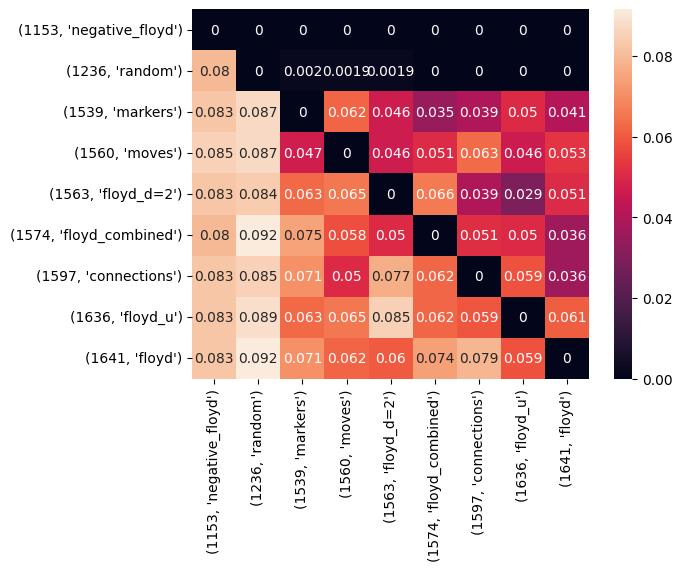

In [8]:
wt_scores = np.concatenate([new_index[i][0]* np.reshape(arr[:, i],(-1,1)) for i in range(len(new_index))], axis=1)/sum([new_index[i][0] for i in range(len(new_index))])
print(wt_scores)

df2 = pd.DataFrame(data = wt_scores, index = new_index, columns = new_index)
ax = sns.heatmap(df2,annot=True,)
df2.sum(axis=1)

In [9]:
games =  (wins1 
        + losses1 
        + wins2 
        + losses2
        + draws1 
        + draws2)
print(games)

[[ 1. 28. 28. 28. 28. 30. 29. 30. 28.]
 [28.  1. 29. 28. 28. 29. 29. 29. 30.]
 [28. 29.  1. 29. 28. 30. 29. 28. 29.]
 [28. 28. 29.  1. 28. 29. 29. 29. 29.]
 [28. 28. 28. 28.  1. 29. 28. 28. 29.]
 [30. 29. 30. 29. 29.  1. 28. 28. 28.]
 [29. 29. 29. 29. 28. 28.  1. 30. 29.]
 [30. 29. 28. 29. 28. 28. 30.  1. 29.]
 [28. 30. 29. 29. 29. 28. 29. 29.  3.]]


In [2]:
!pip install ax-platform

In [1]:
from heuristic_tree_bots import (
    FixedDepthMiniMaxTreePlayer,
    floyd_estimate,
    num_ring_connections,
    num_controlled_markers,
    num_unique_controlled_markers,
    markers_x10,
    total_ring_moves,
    combined_heuristic,
)
from yinsh import YinshGame

import numpy as np

from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.service.utils.report_utils import exp_to_df
from ax.utils.notebook.plotting import init_notebook_plotting, render

In [2]:
ax_client = AxClient()

[INFO 01-15 11:42:59] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


In [3]:
rheuristics = [
    "num_controlled_markers", # floyd
    "num_unique_controlled_markers", #floyd_u
    "num_ring_connections", # connections
    "total_ring_moves", # moves
]

# Create an experiment with required arguments: name, parameters, and objective_name.
ax_client.create_experiment(
    name="tune_combined_heuristics",  # The name of the experiment.
    parameters=[
        {
            "name": rheuristic,  # The name of the parameter.
            "type": "range",  # The type of the parameter ("range", "choice" or "fixed").
            "bounds": [0, 1],  # The bounds for range parameters. 
            # "values" The possible values for choice parameters .
            # "value" The fixed value for fixed parameters.
            "value_type": "float",  # Optional, the value type ("int", "float", "bool" or "str"). Defaults to inference from type of "bounds".
            "log_scale": False,  # Optional, whether to use a log scale for range parameters. Defaults to False.
            # "is_ordered" Optional, a flag for choice parameters.
        } for rheuristic in rheuristics
    ] + [{
        "name": "markersx10",  # The name of the parameter.
        "type": "range",  # The type of the parameter ("range", "choice" or "fixed").
        "bounds": [0, 1],  # The bounds for range parameters. 
        # "values" The possible values for choice parameters .
        # "value" The fixed value for fixed parameters.
        "value_type": "float",  # Optional, the value type ("int", "float", "bool" or "str"). Defaults to inference from type of "bounds".
        "log_scale": False,  # Optional, whether to use a log scale for range parameters. Defaults to False.
        # "is_ordered" Optional, a flag for choice parameters.
    }],
    objectives={"weighted_score": ObjectiveProperties(minimize=False)},  # The objective name and minimization setting.
    parameter_constraints = [
        "num_controlled_markers + num_unique_controlled_markers + num_ring_connections + total_ring_moves <= 1.0", 
        # "num_controlled_markers + num_unique_controlled_markers + num_ring_connections + total_ring_moves >= 1.0"
    ],# Optional, a list of strings of form "p1 >= p2" or "p1 + p2 <= some_bound".
    # outcome_constraints = ["weighted_score <= 11.0","weighted_score >= -1.0"]# Optional, a list of strings of form "constrained_metric <= some_bound".
)
trial=0

[INFO 01-15 11:42:59] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='num_controlled_markers', parameter_type=FLOAT, range=[0.0, 1.0]), RangeParameter(name='num_unique_controlled_markers', parameter_type=FLOAT, range=[0.0, 1.0]), RangeParameter(name='num_ring_connections', parameter_type=FLOAT, range=[0.0, 1.0]), RangeParameter(name='total_ring_moves', parameter_type=FLOAT, range=[0.0, 1.0]), RangeParameter(name='markersx10', parameter_type=FLOAT, range=[0.0, 1.0])], parameter_constraints=[ParameterConstraint(1.0*num_controlled_markers + 1.0*num_ring_connections + 1.0*num_unique_controlled_markers + 1.0*total_ring_moves <= 1.0)]).
[INFO 01-15 11:42:59] ax.modelbridge.dispatch_utils: Using Models.BOTORCH_MODULAR since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 01-15 11:42:59] ax.modelbridge.dispatch_utils: Calculating the number of remaining initialization trials based on 

In [4]:
def play_game(bot1, bot2):
    yinsh_game = YinshGame()
    gs = yinsh_game.get_game_state()
    turns = 0
    while not gs.terminal:
        player = gs.active_player
        move = [bot1, bot2][gs.active_player].make_move(gs)
        # assumed to be valid
        yinsh_game.take_turn(move)
        gs = yinsh_game.get_game_state()
        turns += int(player != gs.active_player)
    if gs.points[0] > gs.points[1]:
        return -1.0/turns # player 2 lost
    elif gs.points[1] > gs.points[0]:
        return 10.0+1.0/turns # player 2 won
    return 5.0+1.0/turns # player 2 draw

def evaluate_heuristic_coeffs(parameters, n=10):
    def estimate(game_state):
        return floyd_estimate(
            game_state,
            marker_heuristic=lambda g,p: parameters["markersx10"]*markers_x10(g,p),
            ring_heuristic=combined_heuristic(
                [
                    num_controlled_markers,
                    num_unique_controlled_markers,
                    num_ring_connections,
                    total_ring_moves,
                ],
                [parameters[name] for name in ["num_controlled_markers", "num_unique_controlled_markers", "num_ring_connections",  "total_ring_moves"]]
            ),
        )
        def mark_estimate(game_state):
            return floyd_estimate(game_state, ring_heuristic=lambda x, y: 0)

        def moves_estimate(game_state):
            return floyd_estimate(game_state, ring_heuristic=total_ring_moves)

    markers = FixedDepthMiniMaxTreePlayer(0, 3, estimate, 1)
    moves = FixedDepthMiniMaxTreePlayer(0, 3, estimate, 1)
    floyd2 = FixedDepthMiniMaxTreePlayer(0, 2, floyd_estimate, 1)
    floyd1 = FixedDepthMiniMaxTreePlayer(0, 1, floyd_estimate, 1)
    floyd3 = FixedDepthMiniMaxTreePlayer(0, 3, floyd_estimate, 1)
    param_bot = FixedDepthMiniMaxTreePlayer(1, 3, estimate, 1)

    result = [0,0]
    c4 = 1 - 1/(4*n) - 7/(32*(n**2)) -19 /(128 *(n**3))
    # n=6
    for bot in [markers, moves, floyd1, floyd2, floyd3]:
        scores = []
        for i in range(n):
            scores.append(play_game(bot, param_bot))
        m = np.mean(scores)
        s = np.sqrt(sum([(s-m) ** 2 for s in scores]) / (n-1))
        result[0] = result[0] + m
        result[1] = np.sqrt(result[1] ** 2 + (s/c4) ** 2) 
    return tuple(result)

# (1539, markers)           4.230460
# (1560, moves)             4.543103
# (1563, floyd_d=2)         4.559770
# (1574, floyd_combined)    4.668966
# (1597, connections)       4.936782
# (1636, floyd_u)           5.318391
# (1641, floyd)             5.420115

In [5]:
ax_client.get_max_parallelism()

[(10, 10), (-1, 3)]

In [13]:
# # add in data frome existing models
# # floyd_combined
# ax_client.attach_trial(
#     parameters = {
#         "num_controlled_markers":1.0, # floyd
#         "num_unique_controlled_markers": 1.0, # floyd_u
#         "num_ring_connections": 1.0, # connections
#         "total_ring_moves": 1.0, # moves
#         "markersx10": 1.0 # makrers
#     }

# )
# ax_client.complete_trial(trial_index=0, raw_data=evaluate_heuristic_coeffs(ax_client.get_trial_parameters(trial_index=0)))

In [6]:
# floyd
ax_client.attach_trial(
    parameters = {
        "num_controlled_markers":1.0, # floyd
        "num_unique_controlled_markers": 0.0, # floyd_u
        "num_ring_connections": 0.0, # connections
        "total_ring_moves": 0.0, # moves
        "markersx10": 1.0 # makrers
    }

)
ax_client.complete_trial(trial_index=trial, raw_data=(33.365941, 11.224827))  # evaluate_heuristic_coeffs(ax_client.get_trial_parameters(trial_index=trial), n=6))
trial += 1

[INFO 01-15 11:45:57] ax.core.experiment: Attached custom parameterizations [{'num_controlled_markers': 1.0, 'num_unique_controlled_markers': 0.0, 'num_ring_connections': 0.0, 'total_ring_moves': 0.0, 'markersx10': 1.0}] as trial 0.
[INFO 01-15 11:45:57] ax.service.ax_client: Completed trial 0 with data: {'weighted_score': (33.365941, 11.224827)}.


In [8]:
# floyd_u
ax_client.attach_trial(
    parameters = {
        "num_controlled_markers": 0.0, # floyd
        "num_unique_controlled_markers": 1.0, # floyd_u
        "num_ring_connections": 0.0, # connections
        "total_ring_moves": 0.0, # moves
        "markersx10": 1.0 # makrers
    }

)
ax_client.complete_trial(trial_index=2, raw_data=evaluate_heuristic_coeffs(ax_client.get_trial_parameters(trial_index=2)))

[INFO 01-13 23:54:35] ax.core.experiment: Attached custom parameterizations [{'num_controlled_markers': 0.0, 'num_unique_controlled_markers': 1.0, 'num_ring_connections': 0.0, 'total_ring_moves': 0.0, 'markersx10': 1.0}] as trial 2.
[INFO 01-14 00:02:00] ax.service.ax_client: Completed trial 2 with data: {'weighted_score': (0.29322, 0.512423)}.


In [9]:
# connections
ax_client.attach_trial(
    parameters = {
        "num_controlled_markers": 0.0, # floyd
        "num_unique_controlled_markers": 0.0, # floyd_u
        "num_ring_connections": 1.0, # connections
        "total_ring_moves": 0.0, # moves
        "markersx10": 1.0 # makrers
    }

)
ax_client.complete_trial(trial_index=3, raw_data=evaluate_heuristic_coeffs(ax_client.get_trial_parameters(trial_index=3)))

[INFO 01-14 00:02:00] ax.core.experiment: Attached custom parameterizations [{'num_controlled_markers': 0.0, 'num_unique_controlled_markers': 0.0, 'num_ring_connections': 1.0, 'total_ring_moves': 0.0, 'markersx10': 1.0}] as trial 3.
[INFO 01-14 00:09:06] ax.service.ax_client: Completed trial 3 with data: {'weighted_score': (0.395988, 0.550351)}.


In [10]:
# moves
ax_client.attach_trial(
    parameters = {
        "num_controlled_markers": 0.0, # floyd
        "num_unique_controlled_markers": 0.0, # floyd_u
        "num_ring_connections": 0.0, # connections
        "total_ring_moves": 1.0, # moves
        "markersx10": 1.0 # makrers
    }

)
ax_client.complete_trial(trial_index=4, raw_data=evaluate_heuristic_coeffs(ax_client.get_trial_parameters(trial_index=4)))

[INFO 01-14 00:09:06] ax.core.experiment: Attached custom parameterizations [{'num_controlled_markers': 0.0, 'num_unique_controlled_markers': 0.0, 'num_ring_connections': 0.0, 'total_ring_moves': 1.0, 'markersx10': 1.0}] as trial 4.
[INFO 01-14 00:16:18] ax.service.ax_client: Completed trial 4 with data: {'weighted_score': (0.396515, 0.548919)}.


In [11]:
# markers
ax_client.attach_trial(
    parameters = {
        "num_controlled_markers": 0.0, # floyd
        "num_unique_controlled_markers": 0.0, # floyd_u
        "num_ring_connections": 0.0, # connections
        "total_ring_moves": 0.0, # moves
        "markersx10": 1.0 # makrers
    }

)
ax_client.complete_trial(trial_index=5, raw_data=evaluate_heuristic_coeffs(ax_client.get_trial_parameters(trial_index=5)))

[INFO 01-14 00:16:18] ax.core.experiment: Attached custom parameterizations [{'num_controlled_markers': 0.0, 'num_unique_controlled_markers': 0.0, 'num_ring_connections': 0.0, 'total_ring_moves': 0.0, 'markersx10': 1.0}] as trial 5.
[INFO 01-14 00:23:40] ax.service.ax_client: Completed trial 5 with data: {'weighted_score': (0.293634, 0.513347)}.


In [7]:
for i in range(25):
    parameters, trial_index = ax_client.get_next_trial()
    # Local evaluation here can be replaced with deployment to external system.
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate_heuristic_coeffs(parameters))

[INFO 01-15 11:46:03] ax.service.ax_client: Generated new trial 1 with parameters {'num_controlled_markers': 0.202586, 'num_unique_controlled_markers': 0.001465, 'num_ring_connections': 0.115976, 'total_ring_moves': 0.582776, 'markersx10': 0.202429}.
[INFO 01-15 12:25:09] ax.service.ax_client: Completed trial 1 with data: {'weighted_score': (21.989104, 10.879046)}.
[INFO 01-15 12:25:09] ax.service.ax_client: Generated new trial 2 with parameters {'num_controlled_markers': 0.280207, 'num_unique_controlled_markers': 0.083497, 'num_ring_connections': 0.44904, 'total_ring_moves': 0.038409, 'markersx10': 0.52387}.
[INFO 01-15 13:03:51] ax.service.ax_client: Completed trial 2 with data: {'weighted_score': (32.027163, 11.19914)}.
[INFO 01-15 13:03:51] ax.service.ax_client: Generated new trial 3 with parameters {'num_controlled_markers': 0.427489, 'num_unique_controlled_markers': 0.03056, 'num_ring_connections': 0.372225, 'total_ring_moves': 0.121361, 'markersx10': 0.571276}.
[INFO 01-15 13:42

KeyboardInterrupt: 

In [28]:
best_parameters, values = ax_client.get_best_parameters()
print(best_parameters)
mean, covariance = values
print(mean, covariance)

/Users/owem/Code/mathanim/sillyGame/yinsh_env/lib/python3.11/site-packages/ax/core/data.py:284: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 01-15 10:05:02] ax.modelbridge.cross_validation: Metric weighted_score was unable to be reliably fit.
[WARNING 01-15 10:05:02] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 01-15 10:05:02] ax.service.utils.best_point: Model fit is poor and data on objective metric weighted_score is noisy; interpret best points results carefully.


{'num_controlled_markers': 0.3468174468261003, 'num_unique_controlled_markers': -0.6002018405110798, 'num_ring_connections': -0.10823302635679488, 'total_ring_moves': -0.6020518267752393, 'markersx10': 1.0}
{'weighted_score': 0.704130055998496} {'weighted_score': {'weighted_score': 0.2644654689149185}}


/Users/owem/Code/mathanim/sillyGame/yinsh_env/lib/python3.11/site-packages/ax/core/data.py:284: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [23]:
evaluate_heuristic_coeffs(best_parameters)

(-0.01155892264047087, 2.8701160420350016)

In [10]:
evaluate_heuristic_coeffs(parameters = {
    "num_controlled_markers":1.0, # floyd
    "num_unique_controlled_markers": 0.0, # floyd_u
    "num_ring_connections": 0.0, # connections
    "total_ring_moves": 0.0, # moves
    "markersx10": 1.0 # markers
})

(0.011453795235178976, 2.8658265490554644)

In [15]:
evaluate_heuristic_coeffs(parameters = {
    "num_controlled_markers":1.0, # floyd
    "num_unique_controlled_markers": 0.0, # floyd_u
    "num_ring_connections": 0.0, # connections
    "total_ring_moves": 0.0, # moves
    "markersx10": 1.0 # markers
}, n=6)

(0.5004114186866429, 0.5940432683096861)

In [16]:
evaluate_heuristic_coeffs(parameters = {
    "num_controlled_markers":1.0, # floyd
    "num_unique_controlled_markers": 0.0, # floyd_u
    "num_ring_connections": 0.0, # connections
    "total_ring_moves": 0.0, # moves
    "markersx10": 1.0 # markers
}, n=6)

(0.32659385398385404, 0.5624901889200679)

In [17]:
evaluate_heuristic_coeffs(parameters = {
    "num_controlled_markers":1.0, # floyd
    "num_unique_controlled_markers": 0.0, # floyd_u
    "num_ring_connections": 0.0, # connections
    "total_ring_moves": 0.0, # moves
    "markersx10": 1.0 # markers
}, n=6)

(0.5007258627761155, 0.5955747699336227)

In [18]:
evaluate_heuristic_coeffs(parameters = {
    "num_controlled_markers":1.0, # floyd
    "num_unique_controlled_markers": 0.0, # floyd_u
    "num_ring_connections": 0.0, # connections
    "total_ring_moves": 0.0, # moves
    "markersx10": 1.0 # markers
}, n=10)

(0.29188703403238214, 0.5141055539836152)

In [14]:

evaluate_heuristic_coeffs(parameters = {'num_controlled_markers': 0.3468174468261003, 'num_unique_controlled_markers': -0.6002018405110798, 'num_ring_connections': -0.10823302635679488, 'total_ring_moves': -0.6020518267752393, 'markersx10': 1.0}
, n=30)

(0.46525879517806773, 0.5441586954368849)

In [16]:
ax_client.attach_trial(
    parameters = {'num_controlled_markers': 0.3468174468261003, 'num_unique_controlled_markers': -0.6002018405110798, 'num_ring_connections': -0.10823302635679488, 'total_ring_moves': -0.6020518267752393, 'markersx10': 1.0}

)
ax_client.complete_trial(trial_index=trial, raw_data=(0.46525879517806773, 0.5441586954368849))
trial+= 1

[INFO 01-14 14:30:33] ax.core.experiment: Attached custom parameterizations [{'num_controlled_markers': 0.346817, 'num_unique_controlled_markers': -0.600202, 'num_ring_connections': -0.108233, 'total_ring_moves': -0.602052, 'markersx10': 1.0}] as trial 81.
[INFO 01-14 14:30:33] ax.service.ax_client: Completed trial 81 with data: {'weighted_score': (0.465259, 0.544159)}.


In [17]:
ax_client.attach_trial(
    parameters = {'num_controlled_markers': 0.3468174468261003, 'num_unique_controlled_markers': -0.6002018405110798, 'num_ring_connections': -0.10823302635679488, 'total_ring_moves': -0.6020518267752393, 'markersx10': 1.0}

)
ax_client.complete_trial(trial_index=trial, raw_data=evaluate_heuristic_coeffs(ax_client.get_trial_parameters(trial_index=trial), n=30))
trial += 1

[INFO 01-14 14:30:52] ax.core.experiment: Attached custom parameterizations [{'num_controlled_markers': 0.346817, 'num_unique_controlled_markers': -0.600202, 'num_ring_connections': -0.108233, 'total_ring_moves': -0.602052, 'markersx10': 1.0}] as trial 82.
[INFO 01-14 14:52:34] ax.service.ax_client: Completed trial 82 with data: {'weighted_score': (0.39656, 0.519782)}.


In [25]:
ax_client.get_trials_data_frame()

[WARNING 01-15 08:33:23] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


,trial_index,arm_name,trial_status,generation_method,weighted_score,num_controlled_markers,num_unique_controlled_markers,num_ring_connections,total_ring_moves,markersx10
0,0,0_0,COMPLETED,Manual,0.396191,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,1_0,COMPLETED,Manual,0.499245,1.000000,0.000000,0.000000,0.000000,1.000000
2,2,2_0,COMPLETED,Manual,0.293220,0.000000,1.000000,0.000000,0.000000,1.000000
3,3,3_0,COMPLETED,Manual,0.395988,0.000000,0.000000,1.000000,0.000000,1.000000
4,4,4_0,COMPLETED,Manual,0.396515,0.000000,0.000000,0.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
128,128,128_0,COMPLETED,BoTorch,-0.017526,-0.517645,-0.233347,0.420753,-0.951381,0.089039
129,129,129_0,COMPLETED,BoTorch,0.051131,-0.471384,-0.642840,0.063733,-1.000000,-0.023741
130,130,130_0,COMPLETED,BoTorch,0.258056,-0.476097,-1.000000,0.997524,-0.902412,0.122181
131,131,131_0,COMPLETED,BoTorch,0.258680,-0.330667,0.345488,-0.065751,-0.871936,1.000000


In [5]:
import nbformat
render(ax_client.get_contour_plot(param_x="num_controlled_markers", param_y="markersx10", metric_name="weighted_score"))

ValueError: Cannot generate plot as there are no trials.

In [20]:
!pip install nbformat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.9/352.9 kB 3.7 MB/s eta 0:00:00a 0:00:01


In [1]:
render(
    ax_client.get_optimization_trace()
) 

NameError: name 'render' is not defined

In [24]:
for i in range(50):
    parameters, trial_index = ax_client.get_next_trial()
    # Local evaluation here can be replaced with deployment to external system.
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate_heuristic_coeffs(parameters, n = 15))

[INFO 01-14 15:28:44] ax.service.ax_client: Generated new trial 83 with parameters {'num_controlled_markers': -1.0, 'num_unique_controlled_markers': 1.0, 'num_ring_connections': -1.0, 'total_ring_moves': -0.440791, 'markersx10': 1.0}.
[INFO 01-14 15:39:56] ax.service.ax_client: Completed trial 83 with data: {'weighted_score': (0.396043, 0.533247)}.
[INFO 01-14 15:39:57] ax.service.ax_client: Generated new trial 84 with parameters {'num_controlled_markers': 0.403922, 'num_unique_controlled_markers': -0.997944, 'num_ring_connections': -0.465054, 'total_ring_moves': -1.0, 'markersx10': 0.654589}.
[INFO 01-14 15:50:21] ax.service.ax_client: Completed trial 84 with data: {'weighted_score': (0.326619, 0.51449)}.
[INFO 01-14 15:50:22] ax.service.ax_client: Generated new trial 85 with parameters {'num_controlled_markers': 0.344973, 'num_unique_controlled_markers': -0.067443, 'num_ring_connections': 0.15599, 'total_ring_moves': 0.151708, 'markersx10': -0.879459}.
[INFO 01-14 16:00:43] ax.servic

In [27]:
for i in range(25):
    parameters, trial_index = ax_client.get_next_trial()
    # Local evaluation here can be replaced with deployment to external system.
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate_heuristic_coeffs(parameters, n = 30))

[INFO 01-15 08:34:34] ax.service.ax_client: Generated new trial 133 with parameters {'num_controlled_markers': 1.0, 'num_unique_controlled_markers': -1.0, 'num_ring_connections': 1.0, 'total_ring_moves': 1.0, 'markersx10': 0.37951}.
[INFO 01-15 08:55:55] ax.service.ax_client: Completed trial 133 with data: {'weighted_score': (0.431513, 0.526984)}.
[INFO 01-15 08:55:57] ax.service.ax_client: Generated new trial 134 with parameters {'num_controlled_markers': -0.551003, 'num_unique_controlled_markers': -0.576116, 'num_ring_connections': -0.235682, 'total_ring_moves': -1.0, 'markersx10': -0.743954}.
[INFO 01-15 09:17:03] ax.service.ax_client: Completed trial 134 with data: {'weighted_score': (0.014977, 0.190743)}.
[INFO 01-15 09:17:05] ax.service.ax_client: Generated new trial 135 with parameters {'num_controlled_markers': 1.0, 'num_unique_controlled_markers': -0.250274, 'num_ring_connections': 0.437739, 'total_ring_moves': 0.942012, 'markersx10': 0.382627}.
[INFO 01-15 09:38:27] ax.servic

KeyboardInterrupt: 